# Clustering

KMeans clustering is a simple way to explore structure in series data, by finding groups of signals with similar properties. Here, we show how to use clustering and how to inspect the results in the form of a spatial map.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

Inspect the data
----------------

Load example data -- time series from spatial data -- and cache it to speed up repeated queries


In [3]:
data = tsc.loadExample('fish-series').toTimeSeries().normalize()
data.cache()
data.dims;

Extract some samples just to look at the typical structure of the time series:

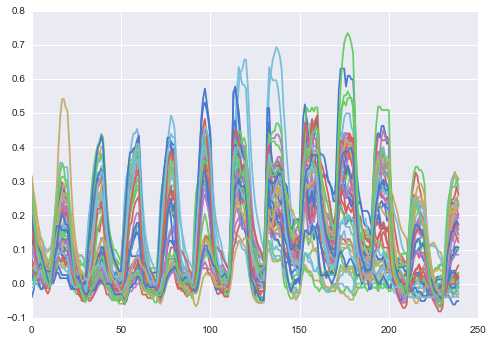

In [4]:
examples = data.subset(nsamples=50, thresh=0.1)
plt.plot(examples.T);

Cluster 
-------
Perform KMeans clustering with 10 clusters:

In [5]:
from thunder import KMeans
model = KMeans(k=10).fit(data)

Plot the time series associated with each of the recovered clusters, with a fixed but arbitrary color scheme:

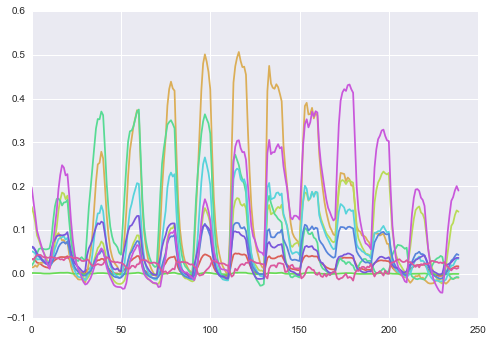

In [6]:
from matplotlib.colors import ListedColormap
cmapCat = ListedColormap(sns.color_palette("hls", 10), name='from_list')
plt.gca().set_color_cycle(cmapCat.colors)
plt.plot(model.centers.T);

Compute a predicted label for each pixel, and collect it as an image of labels:

In [7]:
labels = model.predict(data)
labelImg = labels.pack()

Look at the resulting map as an image, using the same color scheme as for plotting the cluster centers above:

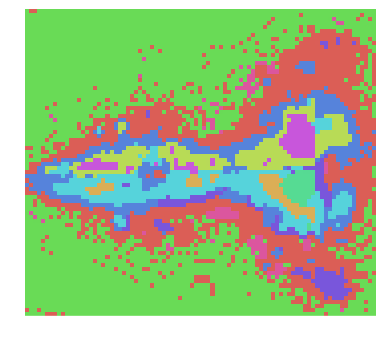

In [8]:
image(labelImg[:,:,0], cmap=cmapCat)

The same colorization can be performed using Thunder's `Colorize` class. In this case the effect is the same as setting the color map in matplotlib's `imshow`, but later `Colorize` will let us perform more complex operations.

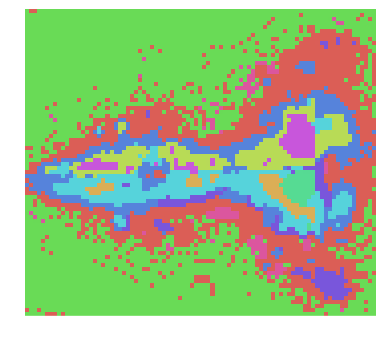

In [9]:
labelMap = Colorize(cmap=cmapCat).transform(labelImg[:,:,0])
image(labelMap)

Smarter color selection
-----------------------
Remember that the color assignments we used above were essentially an arbitrary mapping from cluster center to color. When we do clustering, however, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The ``Colorize`` method ``optimize`` tries to find a set of colors such that similaries among colors match similaries among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

In [10]:
newClrs = Colorize.optimize(model.centers, asCmap=True)

Note that centers that resemble one another have similar colors:

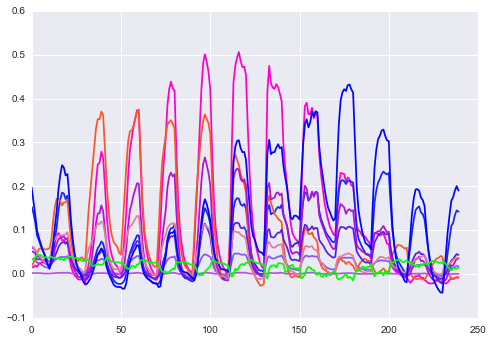

In [11]:
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(model.centers.T);

And if we look at the map, we now see that similar regions are colored similarly (e.g. top and bottom), which makes the spatial organization more clear.

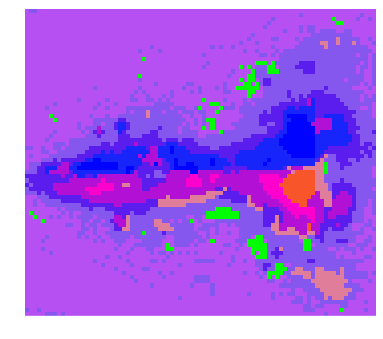

In [12]:
labelMap = Colorize(cmap=newClrs).transform(labelImg[:,:,0])
image(labelMap)

Thresholding
------------
One problem with what we've done so far is that clustering was performed on all pixels, but many of them were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after first subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

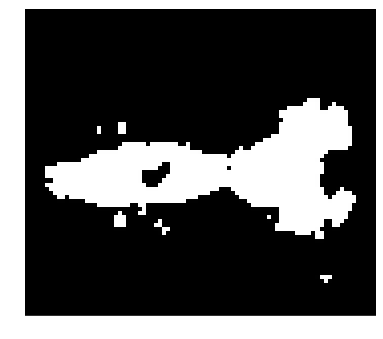

In [13]:
stdMap = data.seriesStdev().pack()
image(stdMap[:,:,0] > 0.05) # try different values of the threshold

Now perform clustering again after filtering the data based on standard deviation

In [14]:
from numpy import std
filtered = data.filterOnValues(lambda x: std(x) > 0.05)
model = KMeans(k=10).fit(filtered)

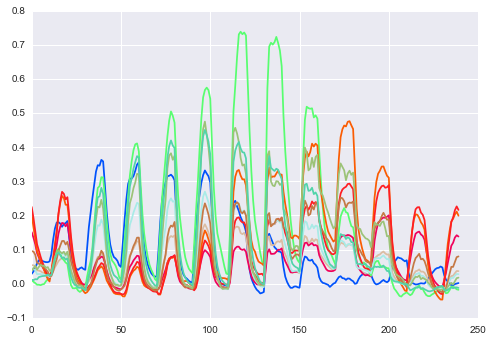

In [15]:
newClrs = Colorize.optimize(model.centers, asCmap=True)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(model.centers.T);

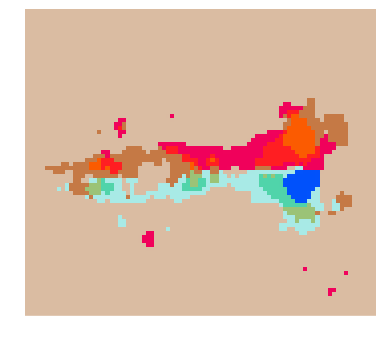

In [16]:
labelImg = model.predict(data).pack()
labelMap = Colorize(cmap=newClrs).transform(labelImg[:,:,0])
image(labelMap)

Adding similarity
-----------------
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A final useful trick is to mask pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

In [17]:
sim = model.similarity(data)
simImg = sim.pack()

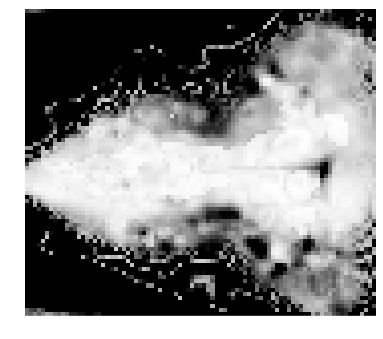

In [18]:
image(simImg[:,:,0], cmap='gray', clim=(0,1))

We can then use this as a linear mask on the colorization output

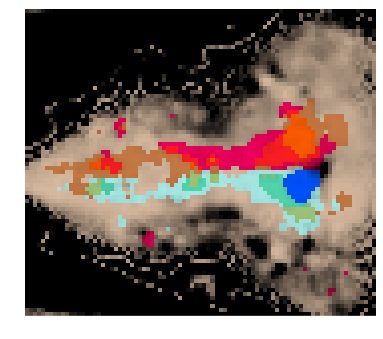

In [19]:
labelMap = Colorize(cmap=newClrs).transform(labelImg[:,:,0], mask=simImg[:,:,0])
image(labelMap)

So far we've always been colorizing one plane, but we can apply the same operation to the full 3D volume (which in this case has just two planes), and then look at a maximum projection.

In [20]:
labelMap = Colorize(cmap=newClrs).transform(labelImg, mask=simImg)

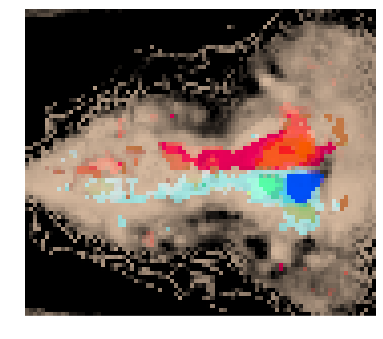

In [21]:
from numpy import amax
image(amax(labelMap,2))